In [4]:
import math

def fill_time_min(size_gb, speed_mbps):
    return (size_gb / (speed_mbps / 8000)) / 60

# AWS instance types sustained network (Mbps), disk space (GB), Ram (GB)
# and annual cost @ 3 yr partial upfront Linux rates ($ / year)
disk_network = {
    'd2.4xlarge': (4000, 24000, 122, 7367),
    # EBS "optimization" took half their bandwidth away from i2s
    'i2.4xlarge': (2000 / 2, 3200, 122, 7875),
    'i3.4xlarge': (4000, 3800, 122, 4923),
    'm5d.4xlarge': (4000, 600, 64, 3206),
    'c5d.4xlarge': (4000, 400, 32, 2610),
    'r5d.4xlarge': (4000, 600, 128, 4188),
    'm5dn.4xlarge': (10000, 600, 64, 3434),
    'i3en.6xlarge': (25000, 15000, 192, 9574)
}

memory_network = {
    'x1e.16xlarge': (10000, 1952, 34794),
    'r4.4xlarge': (4000, 122, 3731),
    'm5.4xlarge': (4000, 64, 2750),
}

num_instances = len(disk_network) + len(memory_network)

fill_vs_cost_disk = {
    k : (fill_time_min(v[1], v[0]), v[1] / v[3], v[3] / v[2], v[3] / v[1]) for (k, v) in disk_network.items()
}

fill_vs_cost_mem = {
    k : (fill_time_min(v[1], v[0]), v[1] / v[2], v[2] / v[1], v[2] / v[1]) for (k, v) in memory_network.items()
}

min_gb = float(
    min(min(v[1] for _, v in c.items()) for c in [fill_vs_cost_disk, fill_vs_cost_mem])
)

def normalize_size(size):
    return 10000 * size
    #return min_gb * size/min_gb

           Type |  Dollars/GB RAM | Fill Time (min) |      ~ (GB) / $
     d2.4xlarge |         60.3852 |        800.0000 |        32577.71
     i2.4xlarge |         64.5492 |        426.6667 |         4063.49
     i3.4xlarge |         40.3525 |        126.6667 |         7718.87
    m5d.4xlarge |         50.0938 |         20.0000 |         1871.49
    c5d.4xlarge |         81.5625 |         13.3333 |         1532.57
    r5d.4xlarge |         32.7188 |         20.0000 |         1432.66
   m5dn.4xlarge |         53.6562 |          8.0000 |         1747.23
   i3en.6xlarge |         49.8646 |         80.0000 |        15667.43
---------------------------------------------------------------------
   x1e.16xlarge |         17.8248 |         26.0267 |          561.02
     r4.4xlarge |         30.5820 |          4.0667 |          326.99
     m5.4xlarge |         42.9688 |          2.1333 |          232.73


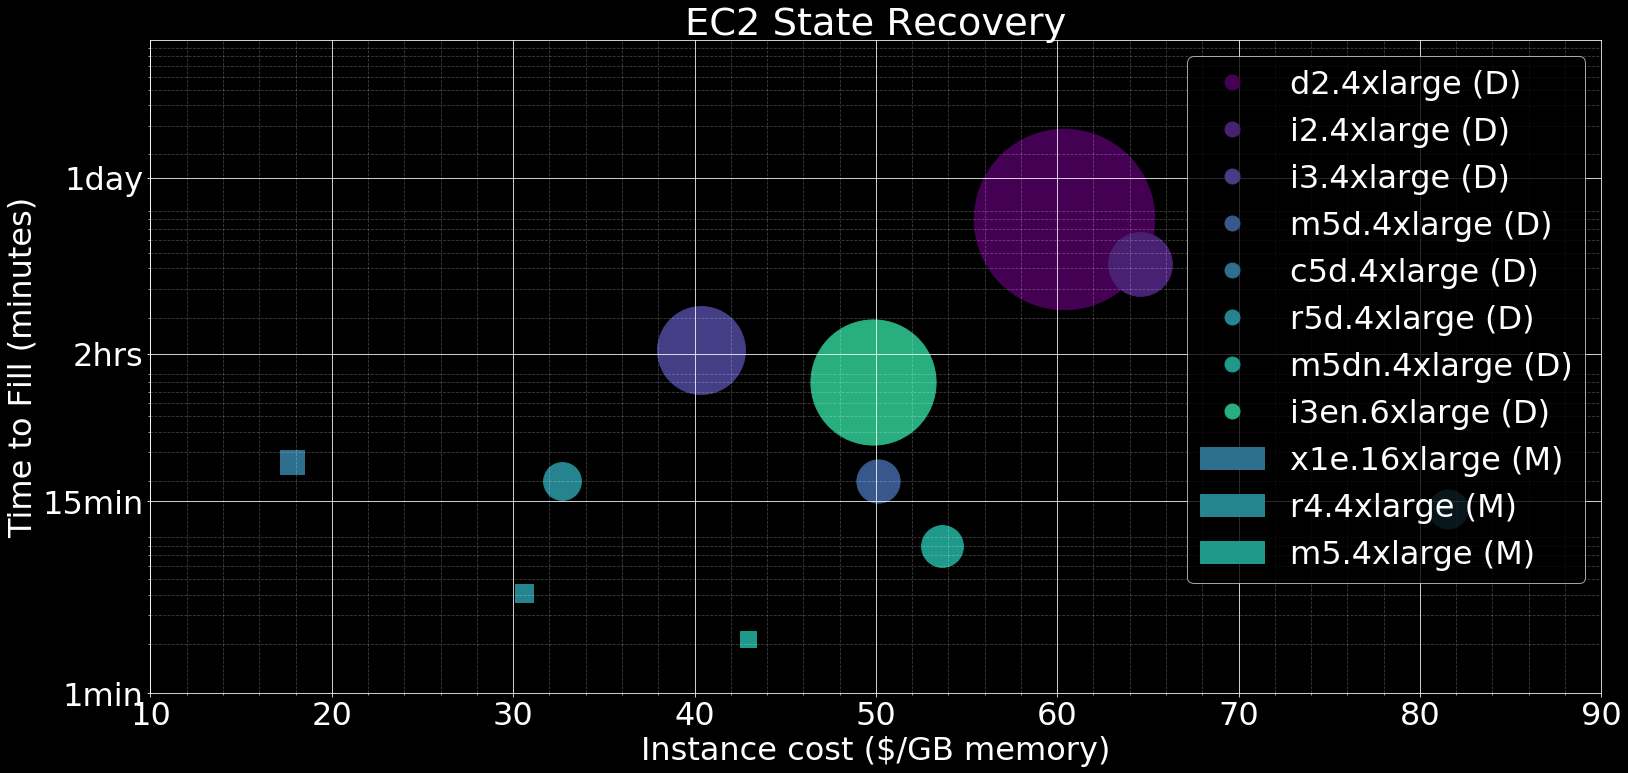

In [5]:
import numpy as np
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

plt.rcParams.update({'font.size': 32})
plt.style.use('dark_background')


fig = plt.figure(figsize=(26,12))
ax1 = fig.add_subplot(111)

handles = []
cmap = matplotlib.cm.get_cmap('viridis')
colors = colors=[cmap(i) for i in np.linspace(0.0, 0.9, num_instances)]

keys = [k for k in fill_vs_cost_disk.keys()]
dollars = [fill_vs_cost_disk[k][2] for k in keys]
time = [fill_vs_cost_disk[k][0] for k in keys]
size = [normalize_size(fill_vs_cost_disk[k][1]) for k in keys]

print('{:>15} | {:>15} | {:>15} | {:>15}'.format('Type', 'Dollars/GB RAM', 'Fill Time (min)', '~ (GB) / $'))
for i in range(len(keys)):
    print('{:>15} | {:>15.4f} | {:>15.4f} | {:>15.2f}'.format(keys[i], dollars[i], time[i], size[i]))
    handles.append(Line2D([0], [0], marker='o', color=colors[i], label=keys[i] + " (D)",
                          ls="", markerfacecolor=colors[i], markersize=15))
    s = ax1.scatter([dollars[i]], [time[i]], s=[size[i]], c=[colors[i]])

print('-' * (18 * 4 - 3))
keys = [k for k in fill_vs_cost_mem.keys()]
dollars = [fill_vs_cost_mem[k][2] for k in keys]
time = [fill_vs_cost_mem[k][0] for k in keys]
size = [normalize_size(fill_vs_cost_mem[k][1]) for k in keys]

for i in range(len(keys)):
    print('{:>15} | {:>15.4f} | {:>15.4f} | {:>15.2f}'.format(keys[i], dollars[i], time[i], size[i]))
    handles.append(mpatches.Patch(color=colors[4+i], label=keys[i] + " (M)"))
    ax1.scatter([dollars[i]], [time[i]], s=[size[i]], marker='s', c=[colors[4+i]])
    
ax1.set_title('EC2 State Recovery')
ax1.set_xlabel('Instance cost ($/GB memory)')
ax1.set_ylabel('Time to Fill (minutes)')
ax1.set_ylim(1, 10000)
ax1.set_xlim(10, 90)
ax1.minorticks_on()
ax1.grid(b=True, which='minor', color='white', linestyle='--', alpha=0.25)
ax1.grid(b=True, which='major', color='white', linestyle='-')
plt.semilogy()
plt.yticks([1, 15, 120, 1440], ['1min', '15min', '2hrs', '1day'])
plt.legend(handles=handles)
plt.show()
fig.savefig('stateful.png', transparent=True)

           Type |  Dollars/GB RAM | Fill Time (min) |       Size (GB)
     d2.4xlarge |          0.3070 |        800.0000 |        32577.71
     i2.4xlarge |          2.4609 |        426.6667 |         4063.49
     i3.4xlarge |          1.2955 |        126.6667 |         7718.87
    m5d.4xlarge |          5.3433 |         20.0000 |         1871.49
    c5d.4xlarge |          6.5250 |         13.3333 |         1532.57
    r5d.4xlarge |          6.9800 |         20.0000 |         1432.66
   m5dn.4xlarge |          5.7233 |          8.0000 |         1747.23
   i3en.6xlarge |          0.6383 |         80.0000 |        15667.43
---------------------------------------------------------------------
   x1e.16xlarge |         17.8248 |         26.0267 |          561.02
     r4.4xlarge |         30.5820 |          4.0667 |          326.99
     m5.4xlarge |         42.9688 |          2.1333 |          232.73


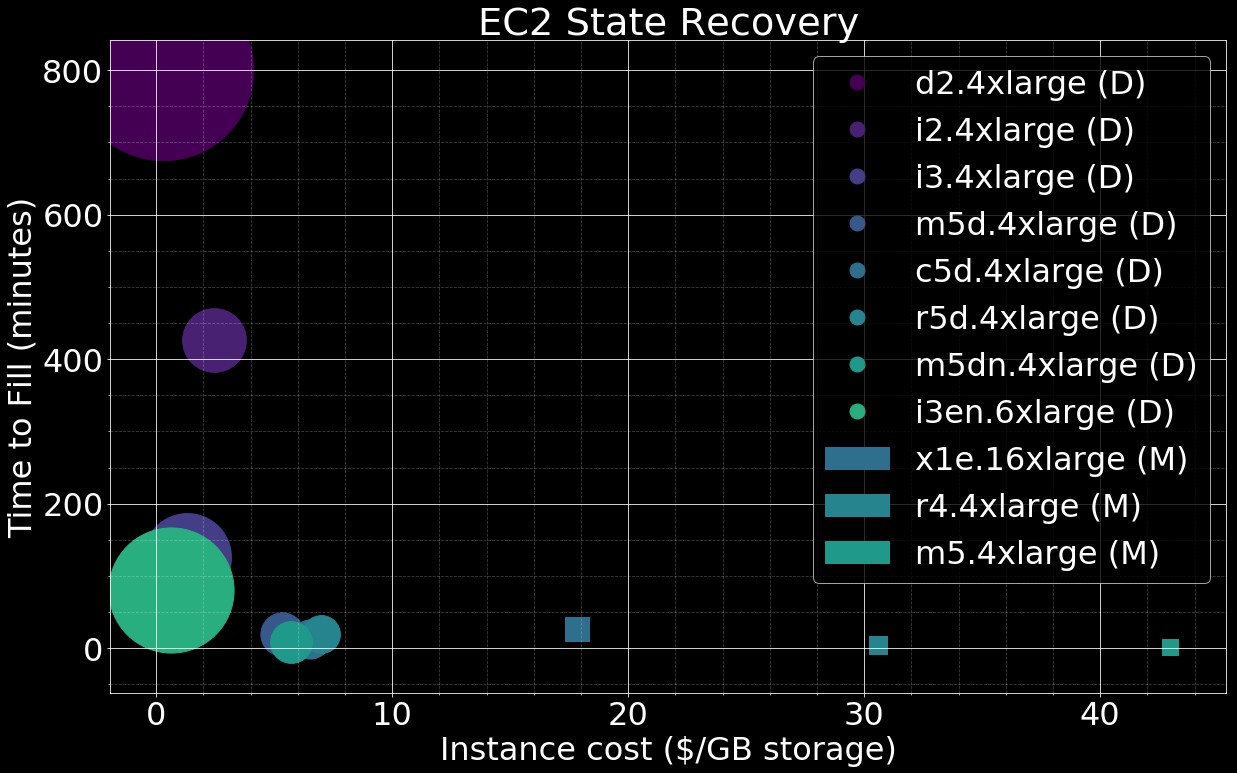

In [6]:
fig = plt.figure(figsize=(20,12))
ax2 = fig.add_subplot(111)

handles = []
cmap = matplotlib.cm.get_cmap('viridis')
colors = colors=[cmap(i) for i in np.linspace(0.0, 0.9, num_instances)]

keys = [k for k in fill_vs_cost_disk.keys()]
dollars = [fill_vs_cost_disk[k][3] for k in keys]
time = [fill_vs_cost_disk[k][0] for k in keys]
size = [normalize_size(fill_vs_cost_disk[k][1]) for k in keys]

print('{:>15} | {:>15} | {:>15} | {:>15}'.format('Type', 'Dollars/GB RAM', 'Fill Time (min)', 'Size (GB)'))
for i in range(len(keys)):
    print('{:>15} | {:>15.4f} | {:>15.4f} | {:>15.2f}'.format(keys[i], dollars[i], time[i], size[i]))
    color=colors[i]
    label=keys[i] + " (D)"
    handles.append(Line2D([0], [0], marker='o', color=colors[i], label=keys[i] + " (D)",
                          ls="", markerfacecolor=colors[i], markersize=15))
    ax2.scatter([dollars[i]], [time[i]], s=[size[i]], c=[colors[i]])

print('-' * (18 * 4 - 3))
keys = [k for k in fill_vs_cost_mem.keys()]
dollars = [fill_vs_cost_mem[k][3] for k in keys]
time = [fill_vs_cost_mem[k][0] for k in keys]
size = [normalize_size(fill_vs_cost_mem[k][1]) for k in keys]

for i in range(len(keys)):
    print('{:>15} | {:>15.4f} | {:>15.4f} | {:>15.2f}'.format(keys[i], dollars[i], time[i], size[i]))
    handles.append(mpatches.Patch(color=colors[4+i], label=keys[i] + " (M)"))
    ax2.scatter([dollars[i]], [time[i]], s=[size[i]], marker='s', c=[colors[4+i]])
    
ax2.set_title('EC2 State Recovery')
ax2.set_xlabel('Instance cost ($/GB storage)')
ax2.set_ylabel('Time to Fill (minutes)')
ax2.minorticks_on()
ax2.grid(b=True, which='minor', color='white', linestyle='--', alpha=0.25)
ax2.grid(b=True, which='major', color='white', linestyle='-')
plt.legend(handles=handles)
plt.show()
fig.savefig('stateful_storage.png', transparent=True)